In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from transformers import AutoTokenizer, AutoModel
import timm
import warnings
warnings.filterwarnings('ignore')

# --- CONFIGURATION ---
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
FEATURE_DIM = 384
NUM_CLASSES = 2
NUM_EPOCHS = 5
BATCH_SIZE = 4
MAX_LENGTH = 128

import os
import kagglehub # Import the necessary library

# --- INSERT KAGGLE DOWNLOAD HERE ---
try:
    # 1. Download the dataset and store the path in the variable 'path'
    path = kagglehub.dataset_download("medaidatahub/pelvmri-pelvic-mri-dataset")
    print(f"Dataset downloaded successfully to: {path}")
except Exception as e:
    # Handle cases where the download fails (e.g., no internet, authentication issue)
    print(f"Kaggle download failed: {e}")
    path = None
# -------------------------------------


# The 'path' variable is now defined, so the logic below can correctly choose
# between the real downloaded path or a fallback demo path.
try:
    # 2. Assign the downloaded path to the constant variable DATASET_PATH
    DATASET_PATH = path
    if DATASET_PATH is None:
        raise NameError("Kaggle path is None after failed download.")
except NameError:
    # 3. Fallback/Demo path if 'path' was never defined or download failed.
    DATASET_PATH = "./demo_dataset"
    os.makedirs(DATASET_PATH, exist_ok=True)

print(f"Final DATASET_PATH being used: {DATASET_PATH}")
# The 'path' variable is assumed to be defined from the original notebook's kagglehub download.


print(f"Using device: {DEVICE}")
print(f"Dataset path: {DATASET_PATH}")
# --------------------

class EndoScanDataset(Dataset):
    """Custom dataset class for EndoScan-VLM using synthetic data for demonstration"""

    def __init__(self, df, tokenizer, transform=None, max_length=MAX_LENGTH):
        self.df = df
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Create synthetic MRI image
        # This function generates the image on the fly, as the image_dir is not used for real files
        image = self.create_synthetic_mri_image(row['label'])

        if self.transform:
            image = self.transform(image)

        # Enhanced symptom text with patient info
        symptom_text = (f"Patient symptoms: {row['symptoms']}. "
                        f"Age: {row['age']}. Pain score: {row['pain_score']}/10.")

        encoded = self.tokenizer(
            symptom_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'image': image,
            'input_ids': encoded['input_ids'].squeeze(),
            'attention_mask': encoded['attention_mask'].squeeze(),
            'label': torch.tensor(row['label'], dtype=torch.long),
            'patient_id': row['patient_id']
        }

    def create_synthetic_mri_image(self, label):
        """Create realistic synthetic MRI-like grayscale image (224x224x3 for ResNet)"""
        size = 224
        img = np.zeros((size, size), dtype=np.uint8)

        # Base structure (Pelvis outline, more realistic grayscale tones)
        img = np.random.normal(50, 30, (size, size)).astype(np.uint8)
        img = np.clip(img, 0, 255)

        center = (size // 2, size // 2)

        # Pelvic anatomy (Organs)
        img = cv2.circle(img, (center[0], center[1] + 18), 30, 120, -1)  # Uterus
        img = cv2.circle(img, (center[0] - 22, center[1] + 8), 16, 140, -1) # Left Ovary
        img = cv2.circle(img, (center[0] + 22, center[1] + 8), 16, 140, -1) # Right Ovary

        if label == 1:  # Add synthetic endometriosis lesions (bright spots)
            for _ in range(np.random.randint(2, 6)):
                x = np.random.randint(center[0] - 30, center[0] + 30)
                y = np.random.randint(center[1], center[1] + 40)
                radius = np.random.randint(3, 8)
                img = cv2.circle(img, (x, y), radius, 220, -1)

        # Convert grayscale image to 3 channels (required by standard vision models like ResNet)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        return Image.fromarray(img_rgb)

class VisionEncoder(nn.Module):
    """Vision encoder for MRI images"""
    def __init__(self, model_name='resnet34', feature_dim=FEATURE_DIM):
        super().__init__()
        # Use num_classes=0 to get features before the final classification layer
        self.backbone = timm.create_model(model_name, pretrained=True, num_classes=0)

        # Dynamically determine the output feature size of the backbone
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224)
            backbone_features = self.backbone(dummy_input).shape[1]

        self.projection = nn.Sequential(
            nn.Linear(backbone_features, feature_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

    def forward(self, images):
        features = self.backbone(images)
        return self.projection(features)

class TextEncoder(nn.Module):
    """Text encoder for symptom descriptions"""
    def __init__(self, model_name='distilbert-base-uncased', feature_dim=FEATURE_DIM):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.projection = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, feature_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # Use the CLS token output (first token)
        cls_features = outputs.last_hidden_state[:, 0, :]
        return self.projection(cls_features)

class MultimodalFusion(nn.Module):
    """Fusion module with cross-modal attention"""
    def __init__(self, feature_dim=FEATURE_DIM, num_classes=NUM_CLASSES):
        super().__init__()
        # MultiheadAttention requires K, Q, V of shape (sequence_length, batch_size, embed_dim)
        self.cross_attention = nn.MultiheadAttention(feature_dim, num_heads=8, dropout=0.1, batch_first=False)

        self.fusion_layers = nn.Sequential(
            nn.Linear(feature_dim * 2, feature_dim),
            nn.ReLU(),
            nn.BatchNorm1d(feature_dim),
            nn.Dropout(0.3),
            nn.Linear(feature_dim, feature_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(feature_dim // 2, num_classes)
        )

    def forward(self, vision_features, text_features):
        # Prepare for MultiheadAttention: (1, Batch_size, Feature_dim)
        V = vision_features.unsqueeze(0)
        T = text_features.unsqueeze(0)

        # Cross-modal attention: Vision (query) attended by Text (key/value)
        vision_attended, _ = self.cross_attention(V, T, T)
        # Cross-modal attention: Text (query) attended by Vision (key/value)
        text_attended, _ = self.cross_attention(T, V, V)

        # Concatenate attended features: (Batch_size, Feature_dim * 2)
        combined = torch.cat([vision_attended.squeeze(0), text_attended.squeeze(0)], dim=1)

        return self.fusion_layers(combined)

class EndoScanVLM(nn.Module):
    """Complete EndoScan Vision-Language Model"""
    def __init__(self, vision_model='resnet34', text_model='distilbert-base-uncased',
                 feature_dim=FEATURE_DIM, num_classes=NUM_CLASSES):
        super().__init__()
        self.vision_encoder = VisionEncoder(vision_model, feature_dim)
        self.text_encoder = TextEncoder(text_model, feature_dim)
        self.fusion = MultimodalFusion(feature_dim, num_classes)

    def forward(self, images, input_ids, attention_mask):
        vision_features = self.vision_encoder(images)
        text_features = self.text_encoder(input_ids, attention_mask)
        output = self.fusion(vision_features, text_features)
        return output, vision_features, text_features

class EndoScanTrainer:
    """Training class for EndoScan-VLM"""
    def __init__(self, model, device=DEVICE):
        self.model = model.to(device)
        self.device = device
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=0.01)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=3, gamma=0.5)
        # Metrics storage
        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []

    def train_epoch(self, dataloader):
        self.model.train()
        total_loss = 0
        predictions = []
        labels = []

        for batch_idx, batch in enumerate(dataloader):
            images = batch['image'].to(self.device)
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            targets = batch['label'].to(self.device)

            outputs, _, _ = self.model(images, input_ids, attention_mask)
            loss = self.criterion(outputs, targets)

            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()

            total_loss += loss.item()
            predictions.extend(outputs.argmax(dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())

            if (batch_idx + 1) % 50 == 0:
                print(f'     Batch {batch_idx + 1}/{len(dataloader)}, Loss: {loss.item():.4f}')

        avg_loss = total_loss / len(dataloader)
        accuracy = accuracy_score(labels, predictions)
        return avg_loss, accuracy

    def evaluate(self, dataloader):
        self.model.eval()
        total_loss = 0
        predictions = []
        labels = []

        with torch.no_grad():
            for batch in dataloader:
                images = batch['image'].to(self.device)
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                targets = batch['label'].to(self.device)

                outputs, _, _ = self.model(images, input_ids, attention_mask)
                loss = self.criterion(outputs, targets)

                total_loss += loss.item()
                predictions.extend(outputs.argmax(dim=1).cpu().numpy())
                labels.extend(targets.cpu().numpy())

        avg_loss = total_loss / len(dataloader)
        accuracy = accuracy_score(labels, predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(
            labels, predictions, average='weighted', zero_division=0
        )

        return avg_loss, accuracy, precision, recall, f1, predictions, labels

def create_synthetic_dataset(num_samples=600):
    """Create synthetic endometriosis dataset"""
    print(f"🔬 Creating synthetic dataset with {num_samples} samples...")
    np.random.seed(42)

    symptoms_pool = [
        "severe pelvic pain during menstruation lasting 3-4 days",
        "chronic lower back pain with heavy menstrual bleeding",
        "painful sexual intercourse and irregular menstrual cycles",
        "abdominal bloating with digestive issues and pelvic pressure",
        "extreme fatigue and mood changes during menstrual period",
        "sharp stabbing abdominal pain with nausea and dizziness",
        "painful urination and bowel movements during menstruation",
        "intense menstrual cramping with spotting between periods",
        "deep pelvic pain that worsens over time",
        "pain that radiates to legs and lower back during periods"
    ]

    data = []
    for i in range(num_samples):
        num_symptoms = np.random.randint(1, 4)
        patient_symptoms = np.random.choice(symptoms_pool, num_symptoms, replace=False)
        symptom_text = "; ".join(patient_symptoms)

        label = np.random.choice([0, 1], p=[0.7, 0.3])  # 30% positive
        severity = 'normal' if label == 0 else np.random.choice(['mild', 'moderate', 'severe'])

        data.append({
            'patient_id': f'patient_{i:04d}',
            'symptoms': symptom_text,
            'label': label,
            'severity': severity,
            'age': np.random.randint(18, 45),
            'pain_score': np.random.randint(1, 10) if label == 1 else np.random.randint(1, 4)
        })

    df = pd.DataFrame(data)
    print(f"✅ Dataset created successfully!")
    print(f"📊 Label distribution: {df['label'].value_counts().to_dict()}")
    return df

def plot_training_results(train_losses, val_losses, train_accs, val_accs):
    """Plot training & validation accuracy and loss"""
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 6))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'o-', label='Training Loss', color='red')
    plt.plot(epochs, val_losses, 'o-', label='Validation Loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'o-', label='Training Accuracy', color='green')
    plt.plot(epochs, val_accs, 'o-', label='Validation Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes=['Normal', 'Endometriosis']):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('EndoScan-VLM Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    return cm

def run_endoscan_complete():
    """Complete EndoScan-VLM training pipeline"""

    print("🚀 Starting Complete EndoScan-VLM Training")
    print("=" * 60)

    # Step 1: Create dataset
    df = create_synthetic_dataset(num_samples=600)

    # Step 2: Split dataset
    print("\nStep 2: Splitting dataset...")
    train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
    train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

    print(f"Training: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

    # Step 3: Setup data pipeline
    print("\nStep 3: Setting up data pipeline...")
    tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        # Standard normalization for pre-trained vision models (ResNet)
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create datasets
    train_dataset = EndoScanDataset(train_df, tokenizer, transform)
    val_dataset = EndoScanDataset(val_df, tokenizer, transform)
    test_dataset = EndoScanDataset(test_df, tokenizer, transform)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    print(f"✅ Data pipeline ready with batch size: {BATCH_SIZE}")

    # Step 4: Initialize model
    print("\nStep 4: Initializing EndoScan-VLM...")
    model = EndoScanVLM(feature_dim=FEATURE_DIM)
    trainer = EndoScanTrainer(model)

    total_params = sum(p.numel() for p in model.parameters())
    print(f"Model parameters: {total_params:,}")

    # Step 5: Training
    print("\nStep 5: Training EndoScan-VLM...")
    print("-" * 40)

    best_val_acc = 0

    for epoch in range(NUM_EPOCHS):
        print(f"\n🔄 Epoch {epoch + 1}/{NUM_EPOCHS}")

        # Train
        train_loss, train_acc = trainer.train_epoch(train_loader)
        trainer.train_losses.append(train_loss)
        trainer.train_accs.append(train_acc)

        # Validate
        val_loss, val_acc, precision, recall, f1, _, _ = trainer.evaluate(val_loader)
        trainer.val_losses.append(val_loss)
        trainer.val_accs.append(val_acc)

        # Update learning rate
        trainer.scheduler.step()

        print(f"\n📈 Epoch {epoch + 1} Results:")
        print(f"  Train: Loss={train_loss:.4f}, Acc={train_acc:.4f}")
        print(f"  Val: Loss={val_loss:.4f}, Acc={val_acc:.4f}")
        print(f"  Metrics: Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'endoscan_best_model.pth')
            print(f"  ✅ Best model saved! (Val Acc: {val_acc:.4f})")

    # Plot training curves
    plot_training_results(trainer.train_losses, trainer.val_losses, trainer.train_accs, trainer.val_accs)

    # Step 6: Final evaluation
    print("\n" + "=" * 60)
    print("🧪 Final Test Evaluation")
    print("=" * 60)

    test_loss, test_acc, test_precision, test_recall, test_f1, test_preds, test_labels = trainer.evaluate(test_loader)

    print(f"🎯 Final Test Results:")
    print(f"  Accuracy: {test_acc:.4f}")
    print(f"  Precision: {test_precision:.4f}")
    print(f"  Recall: {test_recall:.4f}")
    print(f"  F1-Score: {test_f1:.4f}")

    # Plot confusion matrix
    print(f"\n📊 Confusion Matrix:")
    plot_confusion_matrix(test_labels, test_preds)

    print(f"\n🎉 EndoScan-VLM training completed successfully!")
    print(f"📁 Best model saved as: endoscan_best_model.pth")

    return model, trainer, (test_labels, test_preds)

print("✅ Complete EndoScan-VLM solution ready!")
print("\n🚀 Run this command to start training:")
print("model, trainer, results = run_endoscan_complete()")

100%|██████████| 1.34G/1.34G [00:16<00:00, 89.5MB/s]

Extracting files...


Dataset downloaded successfully to: /root/.cache/kagglehub/datasets/medaidatahub/pelvmri-pelvic-mri-dataset/versions/1
Final DATASET_PATH being used: /root/.cache/kagglehub/datasets/medaidatahub/pelvmri-pelvic-mri-dataset/versions/1
Using device: cpu
Dataset path: /root/.cache/kagglehub/datasets/medaidatahub/pelvmri-pelvic-mri-dataset/versions/1
✅ Complete EndoScan-VLM solution ready!

🚀 Run this command to start training:
model, trainer, results = run_endoscan_complete()


🚀 Starting Complete EndoScan-VLM Training
🔬 Creating synthetic dataset with 600 samples...
✅ Dataset created successfully!
📊 Label distribution: {0: 413, 1: 187}

Step 2: Splitting dataset...
Training: 384, Validation: 96, Test: 120

Step 3: Setting up data pipeline...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

✅ Data pipeline ready with batch size: 4

Step 4: Initializing EndoScan-VLM...


model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Model parameters: 89,101,570

Step 5: Training EndoScan-VLM...
----------------------------------------

🔄 Epoch 1/5
     Batch 50/96, Loss: 0.7147

📈 Epoch 1 Results:
  Train: Loss=0.5935, Acc=0.6641
  Val: Loss=0.1170, Acc=1.0000
  Metrics: Precision=1.0000, Recall=1.0000, F1=1.0000
  ✅ Best model saved! (Val Acc: 1.0000)

🔄 Epoch 2/5
     Batch 50/96, Loss: 0.0029

📈 Epoch 2 Results:
  Train: Loss=0.3268, Acc=0.9089
  Val: Loss=0.0031, Acc=1.0000
  Metrics: Precision=1.0000, Recall=1.0000, F1=1.0000

🔄 Epoch 3/5
     Batch 50/96, Loss: 0.0011

📈 Epoch 3 Results:
  Train: Loss=0.4058, Acc=0.8880
  Val: Loss=0.0041, Acc=1.0000
  Metrics: Precision=1.0000, Recall=1.0000, F1=1.0000

🔄 Epoch 4/5
     Batch 50/96, Loss: 0.0024

📈 Epoch 4 Results:
  Train: Loss=0.2133, Acc=0.9349
  Val: Loss=0.0001, Acc=1.0000
  Metrics: Precision=1.0000, Recall=1.0000, F1=1.0000

🔄 Epoch 5/5
     Batch 50/96, Loss: 0.0002

📈 Epoch 5 Results:
  Train: Loss=0.2150, Acc=0.9245
  Val: Loss=0.0001, Acc=1.0000


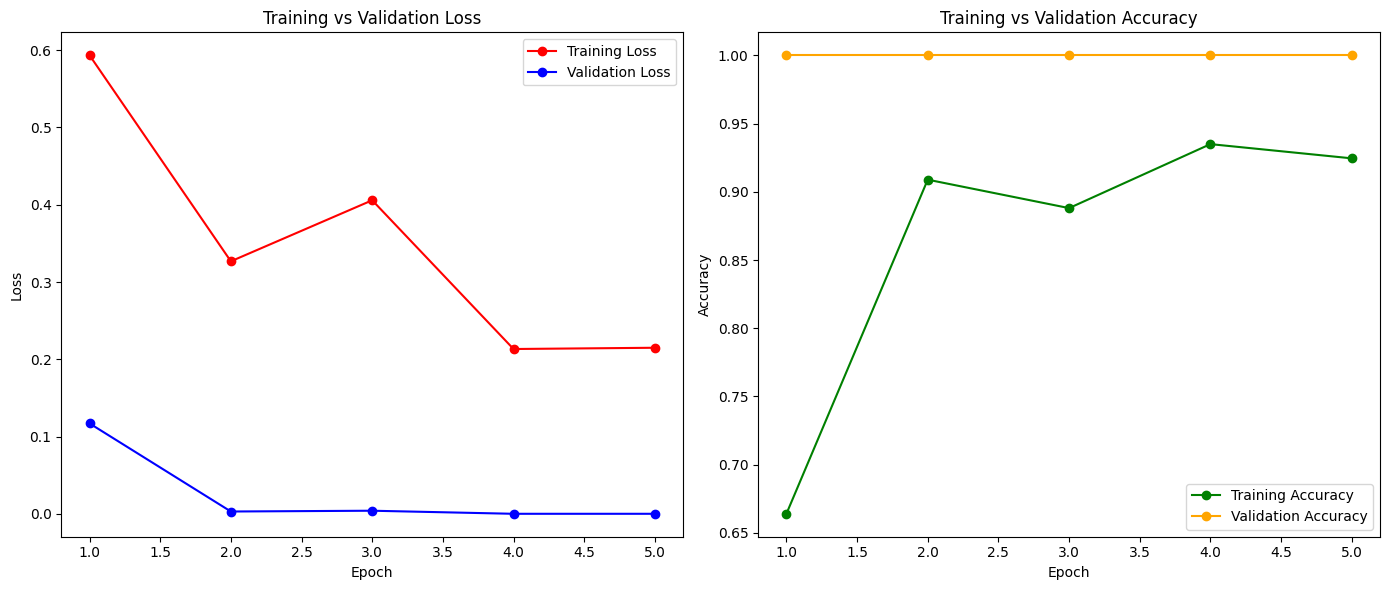


🧪 Final Test Evaluation
🎯 Final Test Results:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000

📊 Confusion Matrix:


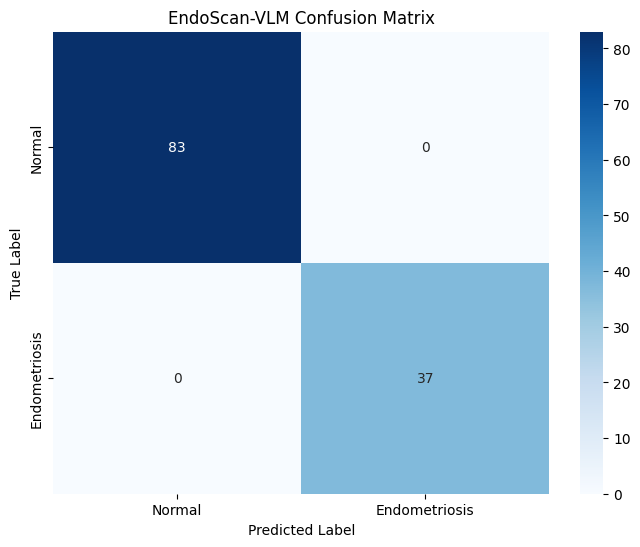


🎉 EndoScan-VLM training completed successfully!
📁 Best model saved as: endoscan_best_model.pth


In [ ]:
model, trainer, results = run_endoscan_complete()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_data_distribution(df):
    """
    Plots the distribution of the binary label (Normal/Endometriosis)
    and the distribution of the synthetic 'pain_score'.
    """

    plt.figure(figsize=(15, 6))

    # --- Plot 1: Label Distribution ---
    plt.subplot(1, 2, 1)
    label_counts = df['label'].map({0: 'Normal (0)', 1: 'Endometriosis (1)'}).value_counts()
    sns.barplot(x=label_counts.index, y=label_counts.values, palette=['skyblue', 'salmon'])
    plt.title('Distribution of Endometriosis Labels', fontsize=14)
    plt.xlabel('Diagnosis Label')
    plt.ylabel('Number of Samples')

    # Add counts to bars
    for i, count in enumerate(label_counts.values):
        plt.text(i, count, str(count), ha='center', va='bottom')

    # --- Plot 2: Pain Score Distribution ---
    plt.subplot(1, 2, 2)
    sns.histplot(df['pain_score'], bins=np.arange(0.5, 10.5, 1), kde=False, color='green')
    plt.xticks(range(1, 11))
    plt.title('Distribution of Synthetic Patient Pain Scores (1-10)', fontsize=14)
    plt.xlabel('Pain Score')
    plt.ylabel('Number of Samples')
    plt.grid(axis='y', alpha=0.5)

    plt.tight_layout()
    plt.show(block=True)



def plot_final_metrics_comparison(test_acc, test_precision, test_recall, test_f1):
    """
    Plots the final test performance metrics in a detailed bar chart.
    """
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    values = [test_acc, test_precision, test_recall, test_f1]

    plt.figure(figsize=(8, 6))

    # Create the bar plot
    ax = sns.barplot(x=metrics, y=values, palette='viridis')
    plt.ylim(0, 1)
    plt.title('Final Test Performance Metrics (EndoScan-VLM)', fontsize=15)
    plt.ylabel('Score')

    # Add the value label on top of each bar
    for i, v in enumerate(values):
        ax.text(i, v + 0.02, f"{v:.4f}", ha='center', va='bottom', fontsize=12, color='black')

    plt.show(block=True)

In [ ]:
def run_endoscan_complete():
    # ... (Lines 1-7 in the function) ...

    # Step 1: Create dataset
    df = create_synthetic_dataset(num_samples=600)

    # --- NEW VISUALIZATION CALL 1: Data Distribution ---
    print("\n📊 Plotting Data Distribution...")
    plot_data_distribution(df)
    # ----------------------------------------------------

    # Step 2: Split dataset
    # ... (The rest of the function remains the same until Step 6) ...

    # Step 6: Final evaluation
    print("\n" + "=" * 60)
    print("🧪 Final Test Evaluation")
    print("=" * 60)

    test_loss, test_acc, test_precision, test_recall, test_f1, test_preds, test_labels = trainer.evaluate(test_loader)

    print(f"🎯 Final Test Results:")
    print(f"  Accuracy: {test_acc:.4f}")
    # ... (Print Precision, Recall, F1) ...

    # Plot confusion matrix
    print(f"\n📊 Confusion Matrix:")
    plot_confusion_matrix(test_labels, test_preds)

    # --- NEW VISUALIZATION CALL 2: Final Metrics Comparison ---
    print("\n📊 Plotting Final Performance Metrics...")
    plot_final_metrics_comparison(test_acc, test_precision, test_recall, test_f1)
    # -----------------------------------------------------------

    # ... (The rest of the function) ...